In [1]:
from phi.torch.flow import *
import matplotlib.pyplot as plt

* Data Generation: Using Provided Sample Solution 

In [2]:
def potential(position: math.Tensor):
    x,y = position.vector
    return (x**2 + y**2 - 1) ** 2

In [3]:
def step(state0: math.Tensor, x_step: float, force_y: math.Tensor):
    update = math.stack([math.expand(x_step, force_y.shape), force_y], channel(vector='x,y'))
    return state0 + update

In [4]:
def solver(force: math.Tensor, state0: math.Tensor, steps: int, x_step: float):
    states = [state0]
    for t in range(steps):
        states.append(step(states[-1], x_step, force.time[t]))
    states = math.stack(states, instance('time'))
    return states

In [5]:
def loss_function(state_sequence: math.Tensor):
    return math.l2_loss(potential(state_sequence.time[1:]))

def sequence_loss(force: math.Tensor, state0: math.Tensor, steps: int, x_step: float):
    return loss_function(solver(force, state0, int(steps), x_step))

In [6]:
gradient_function = math.functional_gradient(sequence_loss, wrt='force')


def optimize(point_id: int, state0: math.Tensor, steps: int, x_step: float, iterations: int,
 learning_rate=0.001, momentum_parameter=0.95) -> math.Tensor:
    force = math.random_uniform(batch(state0), spatial(time=steps), low=-0.1, high=0.1)
    velocity = math.zeros(force.shape)
    for i in range(iterations):
        loss, grad = gradient_function(force, state0, steps, x_step)
        # print("Step: ", i, " Loss: ", loss)
        velocity = momentum_parameter * velocity + learning_rate * grad
        force -= velocity
    print(f"Point ID: {point_id + 1} Final Loss: {loss} ")
    return force

In [7]:
N = 20
X_STEP = 0.1
ITERATIONS = 500  
starting_points = math.tensor((-1, math.random_uniform(instance(points = 100), low=-0.01, high=0.01)),
                              channel(vector='x,y'))
opt_force_vectors = [optimize(idx, starting_point, N, X_STEP, ITERATIONS) 
             for idx, starting_point in enumerate(starting_points.points)]

Point ID: 1 Final Loss: 0.00048383523 
Point ID: 2 Final Loss: 0.00035117654 
Point ID: 3 Final Loss: 0.0005049604 
Point ID: 4 Final Loss: 0.00039669237 
Point ID: 5 Final Loss: 0.0004030297 
Point ID: 6 Final Loss: 0.0004351784 
Point ID: 7 Final Loss: 0.0002609656 
Point ID: 8 Final Loss: 0.0007030522 
Point ID: 9 Final Loss: 0.00074803014 
Point ID: 10 Final Loss: 0.0003580932 
Point ID: 11 Final Loss: 0.00021183862 
Point ID: 12 Final Loss: 0.0004524054 
Point ID: 13 Final Loss: 0.0005395273 
Point ID: 14 Final Loss: 0.00044392707 
Point ID: 15 Final Loss: 0.0005035733 
Point ID: 16 Final Loss: 9.412134e-05 
Point ID: 17 Final Loss: 0.00040711963 
Point ID: 18 Final Loss: 0.00048572206 
Point ID: 19 Final Loss: 0.00034060984 
Point ID: 20 Final Loss: 0.0004125404 
Point ID: 21 Final Loss: 0.00019451983 
Point ID: 22 Final Loss: 0.0005048705 
Point ID: 23 Final Loss: 0.000573476 
Point ID: 24 Final Loss: 0.00042183886 
Point ID: 25 Final Loss: 0.0004248925 
Point ID: 26 Final Loss:

In [8]:
opt_force_vectors = math.stack(opt_force_vectors, dim=batch(points = 100)) # network target

In [13]:
starting_points_f = math.stack(starting_points.vector[1], dim=batch(points = 100)) # network input

* Network Training

In [117]:
nn = dense_net(in_channels=1, out_channels=20, layers=[10], activation='ReLU')
nn

DenseNet(
  (linear0): Linear(in_features=1, out_features=10, bias=True)
  (linear_out): Linear(in_features=10, out_features=20, bias=True)
)

In [118]:
def mse_loss(input: Tensor, target: Tensor):
    prediction = math.native_call(nn, input)
    return math.l2_loss(prediction - target) / len(target[0])

In [119]:
optimizer = adam(net=nn, learning_rate=.01)

In [120]:
print(f"Initial loss: {mse_loss(starting_points_f, opt_force_vectors)}")
for i in range(1500):
    loss = update_weights(nn, optimizer, mse_loss, input=starting_points_f, target=opt_force_vectors)
print(f"Final loss: {loss}")

Initial loss: (pointsᵇ=100) 0.032 ± 0.034 (3e-02...4e-01)
Final loss: (pointsᵇ=100) 0.032 ± 0.034 (3e-02...4e-01)


In [121]:
test_points = math.random_uniform(batch(points = 25), low=-.01, high=0.01)

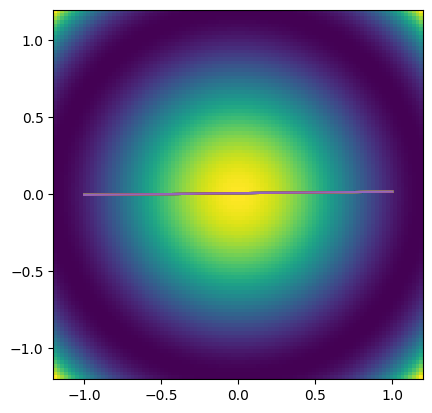

In [122]:
x,y = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
z = (x ** 2 + y ** 2  - 1) ** 2
plt.imshow(z, extent = [-1.2, 1.2, -1.2, 1.2])
x_traj = [-1]
for i in range(20):
    x_traj.append(x_traj[-1] + X_STEP)

for i in range(25):
    f = math.native_call(nn, test_points.points[i])
    y_traj = [test_points.points[0]]
    for i in range(20):
       y_traj.append(y_traj[-1] + f[i])
    plt.plot(x_traj, y_traj)


* Differentiable Physics Training 

In [158]:
class PyhsicalSolverLayer(torch.nn.Module):
    def __init__(self):
        super(PyhsicalSolverLayer, self).__init__()
    
    def forward(self,
                starting_point: torch.Tensor, 
                del_x: torch.Tensor, 
                force_vec: torch.Tensor):
        num_steps = len(force_vec)
        traj = torch.zeros((num_steps + 1, 2))
        traj[0] = starting_point
        for i in range(num_steps):
            traj[i + 1][0] = traj[i][0] + del_x
            traj[i + 1][1] = traj[i][1] + force_vec[i]
        return traj

In [159]:
class DiffPyhsicsModel(torch.nn.Module):
    def __init__(self):
        super(DiffPyhsicsModel, self).__init__()
        self.hidden_layer = torch.nn.Linear(1, 10)
        self.output_layer = torch.nn.Linear(10, 20)
        self.solver_layer = PyhsicalSolverLayer()

    def forward(self,  
                state0: torch.Tensor, 
                steps: int, 
                x_step: torch.Tensor):
        force = state0[1] # network input 
        force = self.hidden_layer(force)
        force = torch.relu(force)
        force = self.output_layer(force) # output of network: force vector
        traj = self.solver_layer(force, state0, steps, x_step)
        return traj

In [160]:
class PyhsicalLoss(torch.nn.Module):
    def __init__(self):
        super(PyhsicalLoss, self).__init__()\
    
    def potential(sequence : torch.Tensor):
        x2y2 = torch.square(sequence) # [x ^ 2, y ^ 2]
        x2y2_sum = torch.sum(x2y2, 1) # [x ^ 2 + y ^ 2]
        x2y2_subs = torch.sub(x2y2_sum, torch.Tensor([1.])) # [x ^ 2 + y ^ 2 -1]
        return torch.square(x2y2_subs)# [(x ^ 2 + y ^ 2 -1) ^ 2]
    
    def forward(sequence: torch.Tensor):
        return torch.nn.MSELoss(potential(sequence))

In [162]:
starting_points = torch.zeros((100,2))

In [190]:
starting_points[:,0] = -1
r1 = -.01
r2 = .01
starting_points[:,1] = torch.rand(100) * (r2 - r1) - r2

In [161]:
solver_involved_network = DiffPyhsicsModel()
physical_loss = PyhsicalLoss()
optimizer_1 = torch.optim.Adam(solver_involved_network.parameters(), lr=1e-2)

In [157]:
f0 = starting_points.vector[1]
for i in range(1500): 
    traj_pred = solver_involved_network(starting_points, 20, X_STEP)
    loss = physical_loss(traj_pred)
    optimizer_1.zero_grad()
    loss.backward()
    optimizer_1.step()
    if(i + 1) % 100 == 0:
        print(f"Iter: {i + 1} loss: {loss}")

(pointsⁱ=100) 4.94e-04 ± 5.7e-03 (-1e-02...1e-02)


TypeError: NativeTensor.__float__ returned non-float (type NotImplementedType)

In [138]:
f0 = starting_points.points[0][1]

In [139]:
f0

0.006962212

In [140]:
type(f0)

phi.math._tensors.NativeTensor

In [144]:
float(f0)

0.006962211802601814

In [145]:
torch.tensor(float(f0))

tensor(0.0070)